### How to use the spectrum class

- you can define quick spectrum subclasses in your script (example in this script)
- you can import spectrum subclasses from the spectrum_models folder (not all working currently)

In [24]:
# python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import json

# All the logging stuff should be defined in your main script!
import logging
logging.basicConfig(level=logging.CRITICAL, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("divertor_spectroscopy")
logger.setLevel(logging.DEBUG)

# my own modules
from divertor_spectroscopy import spectrum
from divertor_spectroscopy import utilities as utils
from divertor_spectroscopy import instrument
from divertor_spectroscopy import analysis
from divertor_spectroscopy import spectral_line_classes
from divertor_spectroscopy.spectrum_models import ip160_cw_760_grating150_Ne_calibration
from divertor_spectroscopy.spectrum_models import ip160_cw_600_grating600_Ne_calibration

ground_path = "//share.ipp-hgw.mpg.de/Documents/frhe/Documents/phd/" # the ground path is used for saving and loading data

### I want clear tasks for every class:
- "spectrum" objects only contain information about specra including physics information (+ what of these parameters is supposed to be fitted)
- "instrument" objects only contain information about the instrument (+ what is supposed to be fitted, i.e. wavelength calibratoin or wavelength shift)
- the analysis class should put everything together

In [25]:
class Example_spectrum(spectrum.Spectrum):
    """This spectrum should include all possibilites of spectral lines, which are impemented in the class "spectrum"
    I want to include a very strict separation of effects from the instrument and physics!
    - Multiplet (N Gaussians with fixed branching ratio) - Possible fits: Intensity (default), line width (electron temperature), shift (ion temperature). todo
    - Stark broadened line (convolution of Gauss and Lorentz) 
    - PEC line (N multiplets whos intensity is connected by plasma parameters)
    Args:
        spectrum (_type_): _description_
    """
    def __init__(self,zeeman=False):
        """This constructor contains all information of the spectrum

        Args:
            zeeman (bool, optional): use zeeman code. Defaults to False.
            mode (str, optional): mode of instrument function. Defaults to "default".
        """
        self.fit_description = []
        
        self.multiplets = []
        self.balmer_lines = []
        self.pec_lines = []
        self.all_tags = []
        
        #self.recommended_background_position = 433.6
        self.recommended_background_position = 401.7
        if True: # example of a multiplet line
            self.add_multiplet_to_model(positions=[412.193],branching_ratios=[1],doppler_temperature=10,intensity=1e17,tag="BII",fit_broadening=False)
        if True: # example of a balmer line (hydrogen broadened by stark broadening)
            self.add_balmer_lines_to_model(lines=["H_delta"],intensities=[5e17],doppler_temperature=1,electron_density=5e19,electron_temperature=1,tag="HI",fit_broadening=False)
        if False: # example of a pec line (will only work with full features)
            special_tags = ["NII 3s1P-3p1D","NII 3d3F-4f1G","NII 3d3F-4f3G"]
            multiplets = [
            spectral_line_classes.Multiplet(positions=[399.5],branching_ratios=[1],doppler_temperature=3,intensity=1,tag=special_tags[0]),
            spectral_line_classes.Multiplet(positions=[402.609, 403.935], branching_ratios=[0.944, 0.056],doppler_temperature=3,intensity=1,tag=special_tags[1]),
            spectral_line_classes.Multiplet(positions=[403.509, 404.132, 404.354, 404.479, 405.692, ], branching_ratios=[0.205, 0.562, 0.175, 0.029, 0.029],doppler_temperature=3,intensity=1,tag=special_tags[2])]
            element = "n"
            ion = 1
            indices = None # leads to default defined in atomic_data
            ne_range = [1e19,1e21]
            Te_range = [1,10]
            ne_count = 100
            Te_count = 101
            electron_density = 5e19 # fitted so this is a guess
            electron_temperature = 3 # fitted so this is a guess
            impurity_density = 5e18 # fitted so this is a guess
            emission_length = 0.1 # not fitted - you might want to adjust this using tomography or simulation
            fit_electron_temperature_nitrogen = False
            save = False
            cache = False
            debug = True
            self.add_pec_lines_to_model(multiplets=multiplets,element=element,ion=ion,indices=indices,ne_range=ne_range,Te_range=Te_range,ne_count=ne_count,Te_count=Te_count,electron_density=electron_density,electron_temperature=electron_temperature,impurity_density=impurity_density,emission_length=emission_length,fit_electron_temperature=fit_electron_temperature_nitrogen,cache=cache,save=save,debug=debug)
        self.clear_tag_multiplicity()
        

### What do we need for building and fitting a spectrum?
- spectrum model
- instrument information

In [26]:
# input to play around with: 
camid = "IP320"
#camid = "Sopra"
camid = "IP160"
instrument_function_mode = "gauss"
#instrument_function_mode = "numeric" # so far only implemented in this example for IP320
#instrument_function_mode = "convolution_entire_spectrum"

#the following should be handled by your datasource
x = np.linspace(-511.5,511.5,1024)
if camid == "IP320":
    wavelength_coefficients = [405,0.02]
    if instrument_function_mode == "gauss":
        width = 0.035
        numeric_instrument_function = None
    if instrument_function_mode == "numeric":
        numeric_instrument_function = [0.00021220119995165606,0.00019513284256424013,0.0002823198573269847,0.00038657522947714524,0.00045161951033189285,0.0005503391990050535,0.0006686644333259218,0.0009482164489144066,0.0013799997601203835,0.00225394578905171,0.0032563658053450704,0.0043575055103115936,0.006893309849733872,0.018259221295405293,0.06952287944111739,0.17674145682582063,0.2745597517061438,0.24361251322797697,0.12555529824878653,0.04256548482899812,0.014466355499747665,0.00584545109823347,0.0030093359301839604,0.0018007117043723608,0.0009214606454422421,0.0004887547203234327,0.00027862940167565234,0.00020620420951823995,0.00019351826821678073,0.000136777512577533] # Example channel 
        width = 0.035
    if instrument_function_mode == "convolution_entire_spectrum":
        numeric_instrument_function = [0.00021220119995165606,0.00019513284256424013,0.0002823198573269847,0.00038657522947714524,0.00045161951033189285,0.0005503391990050535,0.0006686644333259218,0.0009482164489144066,0.0013799997601203835,0.00225394578905171,0.0032563658053450704,0.0043575055103115936,0.006893309849733872,0.018259221295405293,0.06952287944111739,0.17674145682582063,0.2745597517061438,0.24361251322797697,0.12555529824878653,0.04256548482899812,0.014466355499747665,0.00584545109823347,0.0030093359301839604,0.0018007117043723608,0.0009214606454422421,0.0004887547203234327,0.00027862940167565234,0.00020620420951823995,0.00019351826821678073,0.000136777512577533] # Example channel 
        width = 0.035
    
if camid == "Sopra":
    wavelength_coefficients = [434,0.001]
    if instrument_function_mode == "gauss":
        width = 0.001
        numeric_instrument_function = None
if camid == "IP160":
    wavelength_coefficients = [600,0.1]
    width = 0.25
    numeric_instrument_function = None
wavelength = np.array(utils.polynominal(x,*wavelength_coefficients))
#model = Example_spectrum()
model = ip160_cw_760_grating150_Ne_calibration.Ip160_cw_760_grating150_Ne_calibration()
model = ip160_cw_600_grating600_Ne_calibration.Ip160_cw_600_grating600_Ne_calibration()
inst = instrument.Instrument(wavelength=wavelength,width=width,instrument_function_mode=instrument_function_mode,numeric_instrument_function=numeric_instrument_function)

[4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981, 4.301029995663981]
[    0.             0.             0.         ... 15685.42312997
  8990.17440868  4391.14614631]
['NeI']


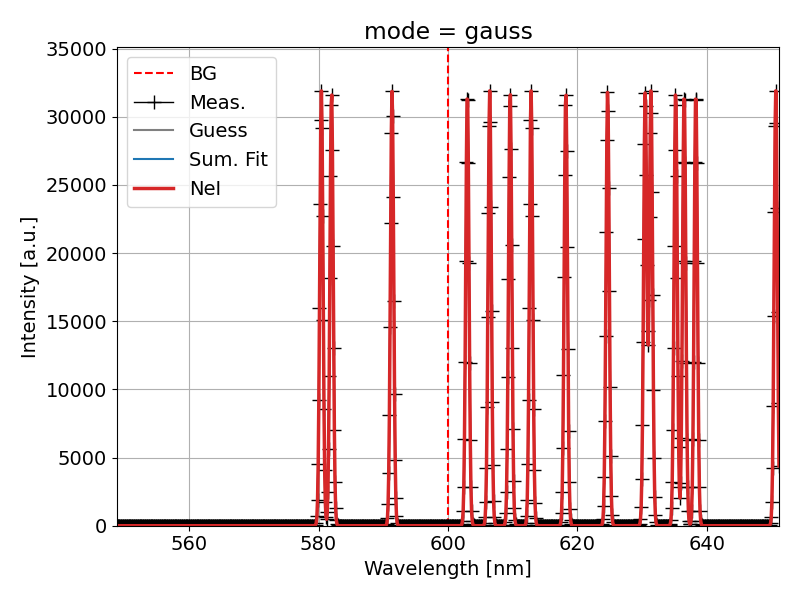

In [27]:
# interactive plotting loves to cause problems - you might want to comment this out
#%matplotlib widget
importlib.reload(analysis) # with the reload method you can update your modules without restarting the python kernel
# creating objects and data to fit
analyse = analysis.Analysis(model=model,instrument=inst)
print(analyse.default_fit_parameters)
signal = analyse.build_spectrum(analyse.instrument.wavelength,*analyse.default_fit_parameters)
print(signal)
experiment_data = signal #+ np.array(np.random.rand(1024))#*1e15 + 1e15)
# fitting
analyse.fit_spectrum(experiment_data=experiment_data)
#displaying
highlight_tags = model.all_tags
print(highlight_tags)
#special_tags = ["NII 3s1P-3p1D","NII 3d3F-4f1G","NII 3d3F-4f3G"]
special_tags = []
scale = "linear"
title = "mode = "+instrument_function_mode
xlim = [411,413]
xlim = None
analyse.display_spectrum(experiment=True,guess=True,fit=True,highlight_tags=highlight_tags,special_tags=special_tags,scale=scale,title=title,xlim=xlim)

In [28]:
analyse.format_fit_output()
analyse.fit_output

fit_description  fit_parameters  fit_parameters_linear     guess  \
0   Intensity_NeI_580.444         4.30103                20000.0  4.300843   
1   Intensity_NeI_582.015         4.30103                20000.0  4.296713   
2   Intensity_NeI_591.363         4.30103                20000.0  4.300378   
3   Intensity_NeI_602.999         4.30103                20000.0  4.292623   
4   Intensity_NeI_606.453         4.30103                20000.0  4.300931   
5   Intensity_NeI_609.616         4.30103                20000.0  4.296946   
6   Intensity_NeI_612.844         4.30103                20000.0  4.300836   
7   Intensity_NeI_618.214         4.30103                20000.0  4.296458   
8   Intensity_NeI_624.672         4.30103                20000.0  4.299277   
9   Intensity_NeI_630.478         4.30103                20000.0  4.298750   
10  Intensity_NeI_631.368         4.30103                20000.0  4.300825   
11  Intensity_NeI_635.185         4.30103                20000.0  4.296701   
12  Intensity_NeI_636.499         4.30103                20000.0  4.292617   
13  Intensity_NeI_638.299         4.30103                20000.0  4.292616   
14  Intensity_NeI_650.652         4.30103                20000.0  4.300938   

    lower_bounds  upper_bounds  
0       1.263455      6.300938  
1       1.263455      6.300938  
2       1.263455      6.300938  
3       1.263455      6.300938  
4       1.263455      6.300938  
5       1.263455      6.300938  
6       1.263455      6.300938  
7       1.263455      6.300938  
8       1.263455      6.300938  
9       1.263455      6.300938  
10      1.263455      6.300938  
11      1.263455      6.300938  
12      1.263455      6.300938  
13      1.263455      6.300938  
14      1.263455      6.300938

In [29]:
from divertor_spectroscopy import datasource_qss

http://archive-webapi.ipp-hgw.mpg.de/ArchiveDB/raw/W7X/QSS_DivertorSpectroscopy/PI_CCD_04_1-QSS60OC092_DATASTREAM/0/Images


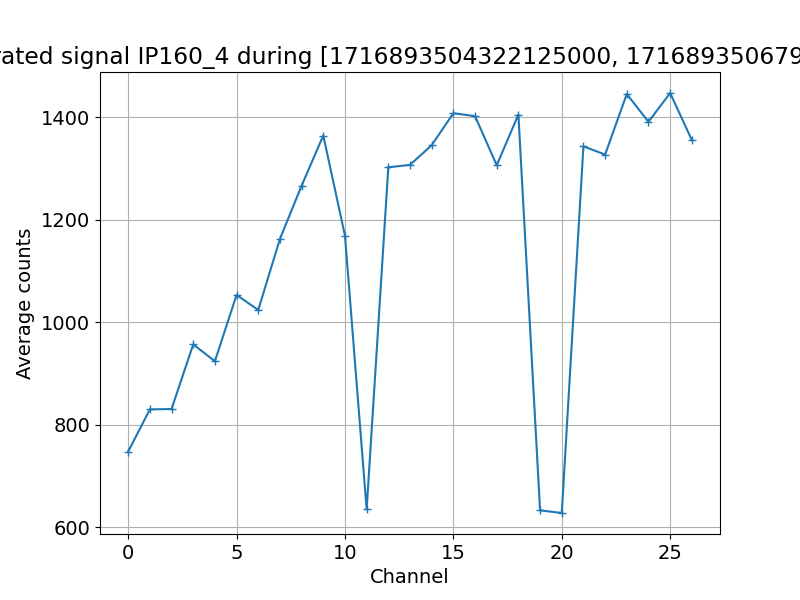

2024-06-21 15:22:15,241 - divertor_spectroscopy.datasource_qss - DEBUG - You need to produce your wavelength vector yourself
2024-06-21 15:22:15,242 - divertor_spectroscopy.datasource_qss - DEBUG - You don't have a wavelength guess for this camera/cw
2024-06-21 15:22:15,244 - divertor_spectroscopy.datasource_qss - DEBUG - You don't have an intensity calibration


In [30]:
camid = "IP160_4"
#time_stamp = [1717069205089125000,1717069227478125000] # unbinned
#time_stamp = [1717069443756125000,1717069446232125000] # binned IP160_2 grating 150 760 nm
time_stamp = [1716893504322125000,1716893506798125000] # binned IP160_4 grating 600 cw 600 nm

ds_qss = datasource_qss.Datasource_qss(time_id=time_stamp, camid=camid,ical=False,wcal=False,debug=True,database_path="ArchiveDB",broken_channels=[])

In [31]:
ds_qss.data["signal_counts"].shape

(100, 27, 1024)

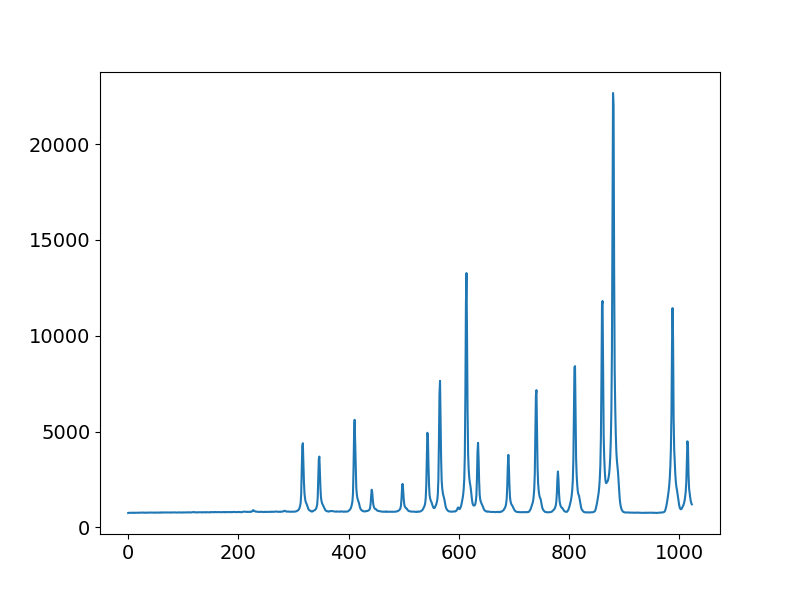

In [32]:
plt.figure(figsize=(8,6))
experiment_data = np.nanmean(ds_qss.data["signal_counts"][:,15],0)
plt.plot(experiment_data)
plt.show()

### Testing wavelength calibration using analysis class

In [33]:
print(541.87+512*0.1)
print(541.87+512*0.13)

593.07
608.4300000000001


\\share.ipp-hgw.mpg.de\documents\frhe\documents\phd\git\divertor_spectroscopy\divertor_spectroscopy\analysis.py:83: RuntimeWarning: invalid value encountered in log10
  intensity_guess = np.log10((experiment_data[position_idx] - self.background_guess)/summed_branching_ratios[dominant_idx] *self.instrument.width * np.sqrt(2 * np.pi))
2024-06-21 15:23:04,207 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-06-21 15:23:04,208 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-06-21 15:23:04,211 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-06-21 15:23:04,212 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-06-21 15:23:04,213 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-06-21 15:23:04,215 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-06-21 15:23:04,216 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-06

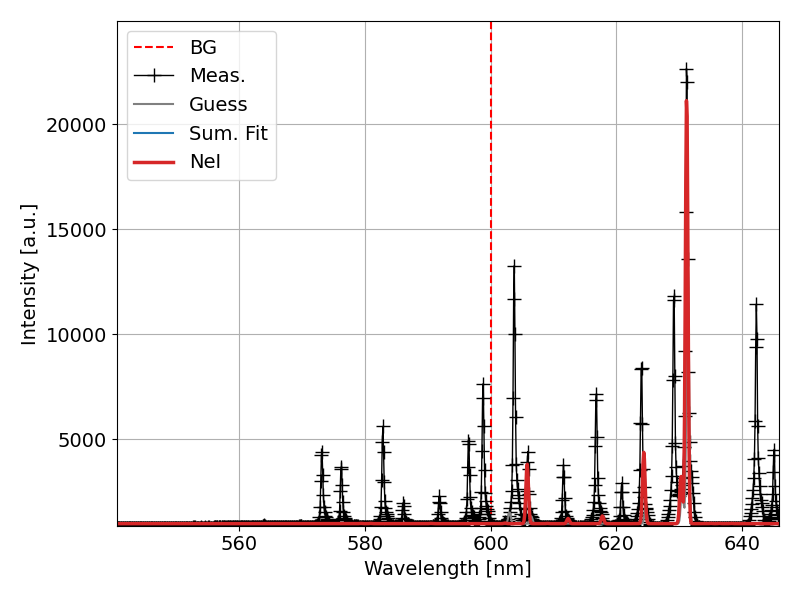

In [38]:
%matplotlib widget
importlib.reload(analysis)
instrument_function_mode = "numeric"
instrument_function_mode = "gauss"
wavelength_coefficients_guess = [593.2,0.103]
lower_bounds = [590,0.09]
upper_bounds = [610,0.15]
width = 0.2
inst = instrument.Instrument(wavelength_coefficients_guess=wavelength_coefficients_guess,lower_bounds=lower_bounds,upper_bounds=upper_bounds,width=width,instrument_function_mode=instrument_function_mode,numeric_instrument_function=numeric_instrument_function)
analyse_wl = analysis.Analysis(model=model,instrument=inst)
analyse_wl.get_default_fit_parameters()
analyse_wl.fit_spectrum(experiment_data=experiment_data,mode="wavelength_calibration")
analyse_wl.set_fit_description()
scale = "linear"
analyse_wl.display_spectrum(highlight_tags=highlight_tags,scale=scale)


In [37]:
analyse_wl.format_fit_output()
analyse_wl.fit_output

fit_description  fit_parameters  fit_parameters_linear  \
0   wavelength_coefficient_0      592.425593             592.425593   
1   wavelength_coefficient_1        0.103165               0.103165   
2      Intensity_NeI_580.444        0.848504               7.055116   
3      Intensity_NeI_582.015        3.326140            2119.046490   
4      Intensity_NeI_591.363        2.540109             346.824130   
5      Intensity_NeI_602.999        3.753511            5669.058766   
6      Intensity_NeI_606.453        1.390082              24.551705   
7      Intensity_NeI_609.616        0.848504               7.055114   
8      Intensity_NeI_612.844        0.848504               7.055113   
9      Intensity_NeI_618.214        0.848504               7.055113   
10     Intensity_NeI_624.672        1.700741              50.204365   
11     Intensity_NeI_630.478        4.018905           10444.905324   
12     Intensity_NeI_631.368        3.126058            1336.773513   
13     Intensity_NeI_635.185        0.848504               7.055113   
14     Intensity_NeI_636.499        0.848504               7.055113   
15     Intensity_NeI_638.299        0.848504               7.055113   
16     Intensity_NeI_650.652        2.233409             171.162605   

         guess  lower_bounds  upper_bounds  
0   593.000000    590.000000     610.00000  
1     0.100000      0.090000       0.15000  
2     0.848504      0.848504       6.05544  
3     1.389429      0.848504       6.05544  
4     2.113118      0.848504       6.05544  
5     3.160938      0.848504       6.05544  
6     1.507452      0.848504       6.05544  
7     0.848504      0.848504       6.05544  
8     0.848504      0.848504       6.05544  
9     0.848504      0.848504       6.05544  
10    0.848504      0.848504       6.05544  
11    3.192193      0.848504       6.05544  
12    1.796126      0.848504       6.05544  
13    0.848504      0.848504       6.05544  
14    0.848504      0.848504       6.05544  
15    0.848504      0.848504       6.05544  
16    2.233409      0.848504       6.05544

In [36]:
asdf

NameError: name 'asdf' is not defined

### Testing the wavelength shift method: 
- this method is used in automated analysis scenarios
    - wavelength calibration is off by the same shift for all channels, because the grating can be moved
    - a new calibration for all channels is computationally expensive and can easily fail on weak channels

\\share.ipp-hgw.mpg.de\documents\frhe\documents\phd\git\divertor_spectroscopy\divertor_spectroscopy\analysis.py:83: RuntimeWarning: invalid value encountered in log10
  intensity_guess = np.log10((experiment_data[position_idx] - self.background_guess)/summed_branching_ratios[dominant_idx] *self.instrument.width * np.sqrt(2 * np.pi))
2024-06-21 15:21:32,540 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-06-21 15:21:32,545 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite


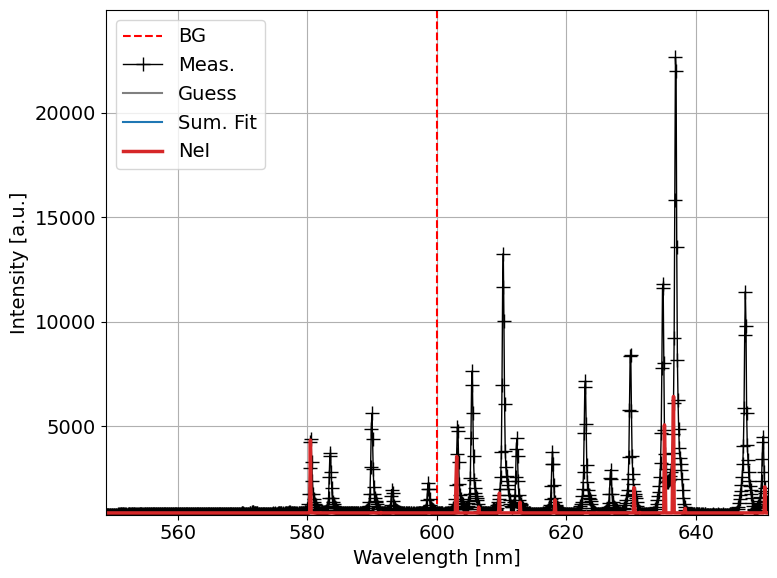

In [ ]:
importlib.reload(analysis)
shift_guess = 0
lower_bounds = [-0.1]
upper_bounds = [0.1]
inst = instrument.Instrument(wavelength=wavelength+0.01,shift_guess=shift_guess,lower_bounds=lower_bounds,upper_bounds=upper_bounds,width=0.035)
analyse_shift=analysis.Analysis(model=model,instrument=inst)
analyse_shift.get_default_fit_parameters()
analyse_shift.fit_spectrum(experiment_data=experiment_data,mode="wavelength_shift")
analyse_shift.set_fit_description()
analyse_shift.display_spectrum(highlight_tags=highlight_tags)


In [ ]:
analyse_shift.format_fit_output()
analyse_shift.fit_output

fit_description  fit_parameters  fit_parameters_linear     guess  \
0        Wavelength_shift        0.017742               0.017742  0.000000   
1   Intensity_NeI_580.444        2.489279             308.516906  2.472402   
2   Intensity_NeI_582.015        0.091542               1.234645  0.091542   
3   Intensity_NeI_591.363        0.364592               2.315221  0.273166   
4   Intensity_NeI_602.999        2.704609             506.534860  2.065302   
5   Intensity_NeI_606.453        1.416837              26.111799  1.377791   
6   Intensity_NeI_609.616        2.044333             110.747260  1.881367   
7   Intensity_NeI_612.844        1.653903              45.071581  1.634169   
8   Intensity_NeI_618.214        1.881833              76.178635  1.655328   
9   Intensity_NeI_624.672        0.091542               1.234645  0.091542   
10  Intensity_NeI_630.478        2.252435             178.827726  1.963370   
11  Intensity_NeI_631.368        0.435982               2.728865  0.345935   
12  Intensity_NeI_635.185        2.889893             776.056159  2.540025   
13  Intensity_NeI_636.499        3.019305            1045.454349  2.518961   
14  Intensity_NeI_638.299        1.620264              41.712255  1.360480   
15  Intensity_NeI_650.652        2.060697             114.999846  2.021876   

    lower_bounds  upper_bounds  
0      -0.100000      0.100000  
1       0.091542      5.298478  
2       0.091542      5.298478  
3       0.091542      5.298478  
4       0.091542      5.298478  
5       0.091542      5.298478  
6       0.091542      5.298478  
7       0.091542      5.298478  
8       0.091542      5.298478  
9       0.091542      5.298478  
10      0.091542      5.298478  
11      0.091542      5.298478  
12      0.091542      5.298478  
13      0.091542      5.298478  
14      0.091542      5.298478  
15      0.091542      5.298478

### From here on this is less of a tutorial, but more my playground to implement other aspects

### Implementation of Zeeman effect
- can the zeeman effect change the branching ratio?
- does the zeeman effect change the instrument function significally?
- as an example use the 3 Neon lines!

### How to implement this?
- you want the standard thing of giving magnetic field and everything is fitted as tons of gaussians
- you want a numeric calculation of line including the zeeman effect if this is important - this could speed up the code!
- you might want to fit the magnetic field at some point!


In [ ]:
class Zeeman_spectrum(spectrum.Spectrum):
    """This spectrum should include all possibilites of spectral lines, which are impemented in the class "spectrum"
    I want to include a very strict separation of effects from the instrument and physics!
    - Multiplet (N Gaussians with fixed branching ratio) - Possible fits: Intensity (default), line width (electron temperature), shift (ion temperature). todo
    - Stark broadened line (convolution of Gauss and Lorentz) 
    - PEC line (N multiplets whos intensity is connected by plasma parameters)
    Args:
        spectrum (_type_): _description_
    """
    def __init__(self,zeeman=False,mode="default",angle_to_magnetic_field=90,doppler_temperature=0):
        """This constructor contains all information of the spectrum

        Args:
            zeeman (bool, optional): use zeeman code. Defaults to False.
            mode (str, optional): mode of instrument function. Defaults to "default".
        """
        with open(ground_path + "qss_analysis/json_files/zeeman_split_lines.json") as f:
            self.zeeman_lines = json.load(f)
        if zeeman:
            self.magnetic_field = 2.5
        else:
            self.magnetic_field = 0
        self.angle_to_magnetic_field = angle_to_magnetic_field       
        self.mode = mode
        if mode == "default":
            self.width = 0.025
        fit_description = []
        
        self.multiplets = []
        self.all_tags = []
        self.balmer_lines = []
        self.pec_lines = []
        
        self.ne_tags = ["NeII 3s2P-3p2D","NeII 3s4P-3p4P","NeII 3s2D-3p2F"]
        line_name = "Ne-II-3713"
        self.add_multiplet_to_model(
            positions=self.zeeman_lines[line_name][str(self.magnetic_field)][str(self.angle_to_magnetic_field)]["wavelength"], 
            branching_ratios=self.zeeman_lines[line_name][str(self.magnetic_field)][str(self.angle_to_magnetic_field)]["branching_ratio"],
            intensity=3,doppler_temperature=doppler_temperature, tag=self.ne_tags[0])
        line_name = "Ne-II-3717"
        self.add_multiplet_to_model(
            positions=self.zeeman_lines[line_name][str(self.magnetic_field)][str(self.angle_to_magnetic_field)]["wavelength"], 
            branching_ratios=self.zeeman_lines[line_name][str(self.magnetic_field)][str(self.angle_to_magnetic_field)]["branching_ratio"],
            intensity=9,doppler_temperature=doppler_temperature, tag=self.ne_tags[1])
        line_name = "Ne-II-3571"
        self.add_multiplet_to_model(
            positions=self.zeeman_lines[line_name][str(self.magnetic_field)][str(self.angle_to_magnetic_field)]["wavelength"], 
            branching_ratios=self.zeeman_lines[line_name][str(self.magnetic_field)][str(self.angle_to_magnetic_field)]["branching_ratio"],
            intensity=1, doppler_temperature=doppler_temperature,tag=self.ne_tags[2])
    

In [ ]:
x = np.linspace(-511.5,511.5,1024)
wavelength = utils.polynominal(x,364,0.019)
inst = instrument.Instrument(wavelength=wavelength,width=0.0275)
model_no_zeeman = Zeeman_spectrum(zeeman=False)
model_doppler = Zeeman_spectrum(zeeman=False,doppler_temperature=3)
model_zeeman_pi = Zeeman_spectrum(zeeman=True,angle_to_magnetic_field=90)
model_zeeman_sigma = Zeeman_spectrum(zeeman=True,angle_to_magnetic_field = 0)
analyse_no_zeeman = analysis.Analysis(instrument=inst,model=model_no_zeeman)
analyse_doppler = analysis.Analysis(instrument=inst,model=model_doppler)
analyse_zeeman_sigma = analysis.Analysis(instrument=inst,model=model_zeeman_sigma)
analyse_zeeman_pi = analysis.Analysis(instrument=inst,model=model_zeeman_pi)

### Display one Zeeman spectrum with all the parts of the lines
- do the branching ratios change?

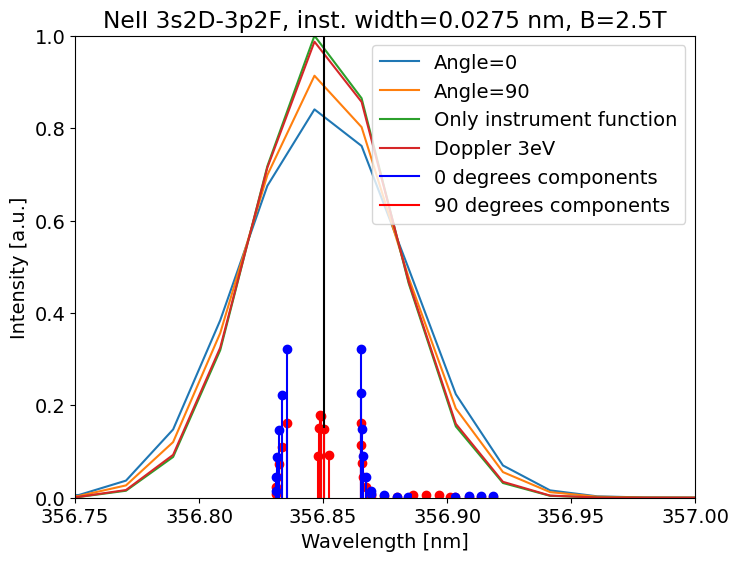

In [ ]:
x = analyse_no_zeeman.instrument.wavelength
plt.figure(figsize=(8,6))
index = 2
for tag in [analyse_no_zeeman.model.ne_tags[index]]:
    plt.plot(x,analyse_zeeman_sigma.build_spectrum(x,*analyse_zeeman_sigma.default_fit_parameters,filter=tag)/np.max(analyse_no_zeeman.build_spectrum(x,*analyse_no_zeeman.default_fit_parameters,filter=tag)),label="Angle=0")
    plt.plot(x,analyse_zeeman_pi.build_spectrum(x,*analyse_zeeman_pi.default_fit_parameters,filter=tag)/np.max(analyse_no_zeeman.build_spectrum(x,*analyse_no_zeeman.default_fit_parameters,filter=tag)),label="Angle=90")
    plt.plot(x,analyse_no_zeeman.build_spectrum(x,*analyse_no_zeeman.default_fit_parameters,filter=tag)/np.max(analyse_no_zeeman.build_spectrum(x,*analyse_no_zeeman.default_fit_parameters,filter=tag)),label="Only instrument function")
    plt.plot(x,analyse_doppler.build_spectrum(x,*analyse_doppler.default_fit_parameters,filter=tag)/np.max(analyse_no_zeeman.build_spectrum(x,*analyse_no_zeeman.default_fit_parameters,filter=tag)),label="Doppler 3eV")
ylim = [0,1]
if index == 2:
    xlim = [356.75,357]
if index == 1:
    xlim = [369.3,369.55]
if index == 0:
    xlim = [371.2,371.45]
plt.xlim(*xlim)

plt.ylim(*ylim)
if True:
    for m in analyse_no_zeeman.model.multiplets:
        for i,component in enumerate(m.branching_ratios):
            plt.axvline(x=m.positions[i],ymax=2*component,color="black")
            plt.scatter(m.positions[i],y=2*component*ylim[1],color="black")
if True:
    for m in analyse_zeeman_pi.model.multiplets:
        for i,component in enumerate(m.branching_ratios):
            plt.axvline(x=m.positions[i],ymax=3*component,color="red")
            plt.scatter(m.positions[i],y=3*component*ylim[1],color="red")
if True:
    for m in analyse_zeeman_sigma.model.multiplets:
        for i,component in enumerate(m.branching_ratios):
            plt.axvline(x=m.positions[i],ymax=3*component,color="blue")
            plt.scatter(m.positions[i],y=3*component*ylim[1],color="blue")

plt.plot([],[],label="0 degrees components",color="blue")
plt.plot([],[],label="90 degrees components",color="red")
plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Intensity [a.u.]")
plt.title("{}, inst. width={} nm, B=2.5T".format(tag,analyse_no_zeeman.instrument.width))
plt.show()

In [ ]:
from divertor_spectroscopy import spectrum
importlib.reload(spectrum)
predicted_positions = analyse_zeeman_pi.model.multiplets[1].positions
predicted_ratios = analyse_zeeman_pi.model.multiplets[1].branching_ratios
measured_positions = np.array([366.40740524, 369.42144631, 370.96222012, 373.49388158,
         375.12458933, 376.62612898, 377.71357821])
measured_ratios = np.array([0.17404514, 0.43402778, 0.10503472, 0.05251736, 0.01736111,
         0.11545139, 0.1015625 ])
df = spectrum.redistribute_branching_ratios(predicted_positions=predicted_positions,predicted_ratios=predicted_ratios,measured_positions=measured_positions,measured_ratios=measured_ratios)
df

(array([366.37913186, 366.38127198, 366.38337108, 366.38542819,
        366.40423483, 366.406371  , 366.40846615, 366.4105193 ,
        366.42934547, 366.4314777 , 366.4335689 , 366.43561808,
        369.39592394, 369.39593966, 369.39594969, 369.39595263,
        369.39595402, 369.42144631, 369.42145773, 369.42145776,
        369.42146345, 369.42146347, 369.44695497, 369.44697073,
        369.44698075, 369.44698362, 369.44698504, 370.9267534 ,
        370.94181206, 370.95462632, 370.96965656, 370.98253374,
        370.99753593, 373.46558342, 373.46563067, 373.46566196,
        373.49386988, 373.49386992, 373.49388645, 373.49388665,
        373.52209883, 373.52214672, 373.52217724, 375.08069704,
        375.12456652, 375.12456674, 375.16844649, 376.59633119,
        376.59851265, 376.60071535, 376.60293891, 376.62283887,
        376.62503107, 376.62724448, 376.62947875, 376.64933983,
        376.65154278, 376.65376694, 376.65601194, 377.6769542 ,
        377.692486  , 377.70585103, 377.

### Can the polarization of the zeeman effect change the branching ratio of multiplets?
- take unperturbed position and look sum up intensities for the sigma and pi model

NeII 3s2P-3p2D
No Zeeman:  0.6000000000000001
Sigma:  0.6000002548295871
Pi  0.5999998582961983
No Zeeman:  0.06666666666666667
Sigma:  0.06666645227801798
Pi  0.06666678814999911
No Zeeman:  0.33333333333333326
Sigma:  0.3333332843189115
Pi  0.3333333435515361
NeII 3s4P-3p4P
No Zeeman:  0.3500000000000001
Sigma:  0.3499990484443626
Pi  0.35000035363094106
No Zeeman:  0.15000000000000002
Sigma:  0.15000002013188818
Pi  0.14999999985948734
No Zeeman:  0.15000000000000002
Sigma:  0.15000012913453495
Pi  0.1499989890087874
No Zeeman:  0.04444444444444445
Sigma:  0.04444660781772103
Pi  0.04444656048308604
No Zeeman:  0.1388888888888889
Sigma:  0.13888860615861906
Pi  0.13888677895268908
No Zeeman:  0.1388888888888889
Sigma:  0.13888724976322203
Pi  0.13888650080101106
No Zeeman:  0.027777777777777776
Sigma:  0.027777630075570815
Pi  0.02777999070876963
NeII 3s2D-3p2F
No Zeeman:  0.5714285714285715
Sigma:  0.5714502406470481
Pi  0.5685673333216279
No Zeeman:  0.028571428571428567
Sigma:  0

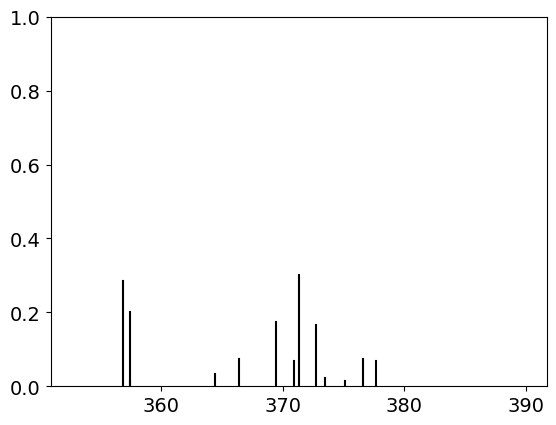

In [ ]:
for m in analyse_no_zeeman.model.multiplets:
    print(m.tag)
    for i,component in enumerate(m.branching_ratios):
        plt.axvline(x=m.positions[i],ymax=0.5*component,color="black")
        sigma = 0
        for m_sigma in analyse_zeeman_sigma.model.multiplets:
            for i_sigma,component_sigma in enumerate(m_sigma.branching_ratios):
                if np.abs(m.positions[i]-m_sigma.positions[i_sigma])<0.1:
                    sigma+=component_sigma
        pi = 0
        for m_pi in analyse_zeeman_pi.model.multiplets:
            for i_pi,component_pi in enumerate(m_pi.branching_ratios):
                if np.abs(m.positions[i]-m_pi.positions[i_pi])<0.05:
                    pi+=component_pi
        print("No Zeeman: ",m.branching_ratios[i])
        print("Sigma: ",sigma)
        print("Pi ",pi)

### Colorschemes and displaying:

In [ ]:
from divertor_spectroscopy.spectrum_models import ip320_example_spectrum_colors

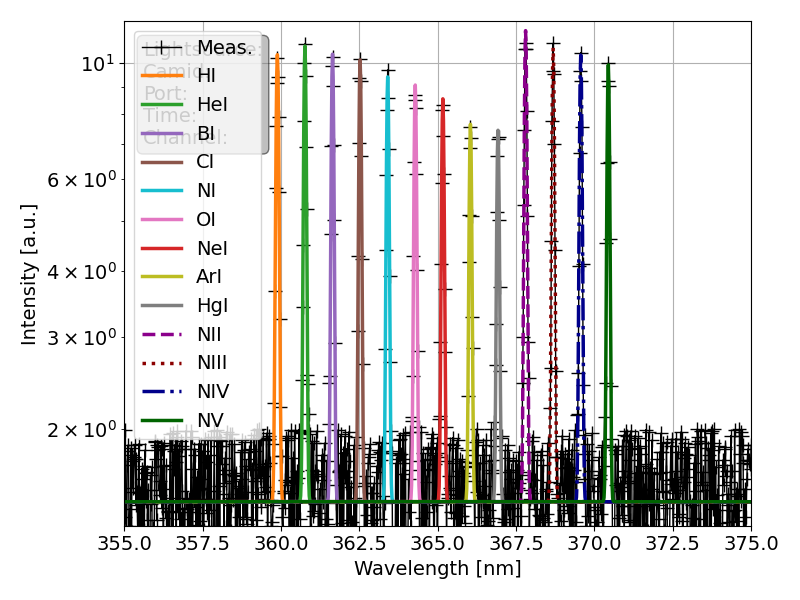

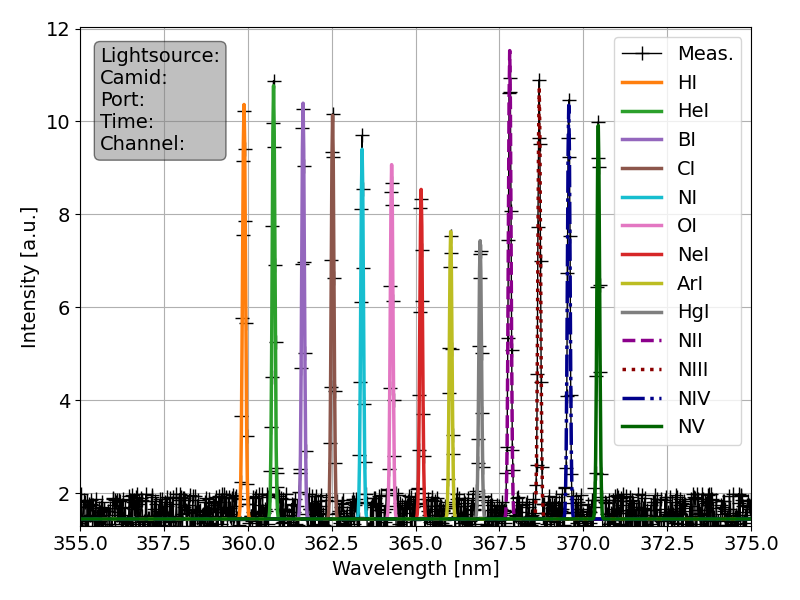

In [63]:
importlib.reload(ip320_example_spectrum_colors)
wavelength=np.linspace(355,375,1024)
width = 0.04
model = ip320_example_spectrum_colors.Ip320_example_spectrum_colors(zeeman=False,wavelength=wavelength)
inst = instrument.Instrument(wavelength = wavelength, width = width)
analyse_colors = analysis.Analysis(model,inst)
experiment_data = analyse_colors.build_spectrum(wavelength,*analyse_colors.default_fit_parameters)+np.random.rand(1024)+1
analyse_colors.get_default_fit_parameters()
analyse_colors.fit_spectrum(experiment_data=experiment_data)
analyse_colors.set_fit_description()

show_fit = False
show_guess = False
yscale = ["log","linear"]
show_background_guess = False
save_path_input = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/Reports/thesis/Weekly_meetings/04_description_qss/" + "color_schemes_lines"+"_"+mode
special_tags = []

title_box = "Lightsource:\nCamid:\nPort:\nTime:\nChannel:"

if True:
    special_tags = ["NII","NIII","NIV","NV"]
    save_path_input = save_path_input + "_special_tags"
for scale in yscale:
    analyse_colors.display_spectrum(title_box=title_box,highlight_tags=model.all_tags,fit=show_fit,guess=show_guess,scale=scale,background_guess=show_background_guess,special_tags=special_tags,save_path=save_path_input)